## Word2Vec using Gensim

Testing Word2Vec implementation by Gensim on Movie Reviews dataset provided by NLTK.

In [1]:
import string
import re
from random import shuffle
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
import spacy
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

%matplotlib inline

np.seterr(all='raise')

nlp = spacy.load("en_core_web_sm")
stpwords = list(sorted(list(set(stopwords.words('english') + list(string.punctuation))))) # + list(nlp.Defaults.stop_words)

# init callback class
class Word2VecEpochCallback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.loss = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.loss.append(loss)
        else:
            self.loss.append(loss - self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss

# Download if you don't have already!
# nltk.download('movie_reviews')

In [2]:
def execute_spacy(word):
    try:
        return [w.lemma_ for w in nlp(re.sub(r'[-+=:_$@!#\/\\]', "", word), disable=["parser"]) if len(w) > 0][0]
    except:
        return ""

def is_number(word):
    try:
        complex(word) # for int, long, float and complex
    except ValueError:
        return False
    return True


# Review categories
print(movie_reviews.categories()) # Output: [u'neg', u'pos']
 
# Total positive reviews
print(len(movie_reviews.fileids('pos'))) # Output: 1000
 
# Total negative reviews
print(len(movie_reviews.fileids('neg'))) # Output: 1000

movie_reviews_docs = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category)[:30]:
        #documents.append((list(movie_reviews.words(fileid)), category))
        phrases = " ".join(movie_reviews.words(fileid)).split(".")
        movie_reviews_docs.append((phrases, category))

print("===> Starting...")
documents = []
with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
    for phrases, category in movie_reviews_docs:
        for phrase in phrases:
            words = phrase.split()
            words = [word for word in words if word not in stpwords and not is_number(word) and len(word) > 2]
            if len(words) > 0:
                fwords = [word for word in exc.map(execute_spacy, words, chunksize=5) if len(word) > 0]
                documents.append((fwords, category))
shuffle(documents)
print("===> Finished...")

['neg', 'pos']
1000
1000
===> Starting...
===> Finished...


In [3]:
print(f"Qtd. Documents: {len(documents)}")
print(f"Qtd. Words: {np.sum([len(document[0]) for document in documents])}")
print("-" * 20)
print("Examples: ")
for document in documents[:10]:
    print(document[1], ":", document[0][:5])

Qtd. Documents: 1710
Qtd. Words: 20915
--------------------
Examples: 
pos : ['film', 'however', 'good']
neg : ['occasionally', 'little', 'flickering', 'sound', 'whirs']
neg : ['one', 'long', 'steadicam', 'shot', 'meet']
neg : ['anything', 'like', 'depict', 'go', 'incredibly']
neg : ['play', 'describes', 'film', 'opening', 'scene']
pos : ['review', 'small', 'enchanting', 'movie', 'heart']
neg : ['probably', 'refuge', 'restraint', 'amidst', 'huff']
pos : ['other', 'say', 'special', 'effect', 'cheesy']
neg : ['work', 'fine', 'since', 'character', 'kill']
neg : ['chan', 'come', 'endearing', 'normal', 'guy']


In [4]:
sentences = [document[0] for document in documents]

callback = Word2VecEpochCallback()

w2v = Word2Vec(
    min_count=2,
    window=5,
    sg=1,
    size=100,
    compute_loss=True,
    workers=cpu_count()
)
w2v.build_vocab(sentences)
w2v.train(sentences, 
    total_examples=w2v.corpus_count, 
    epochs=100,
    compute_loss=True, # set compute_loss = True
    callbacks=[callback]
)

(1673165, 2091500)

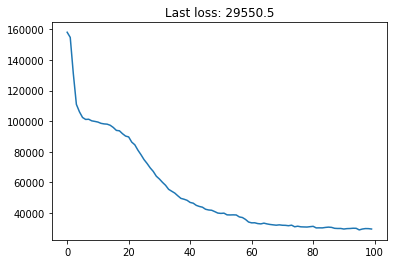

In [5]:
plt.title(f"Last loss: {np.round(callback.loss[-1], 3)}")
plt.plot(callback.loss)
plt.show()

In [6]:
words, vectors = [], []
for i, word in enumerate(w2v.wv.vocab):
    words.append(word)
    vectors.append(w2v.wv[word])
vectors = np.asarray(vectors)
print(vectors.shape)

(2709, 100)


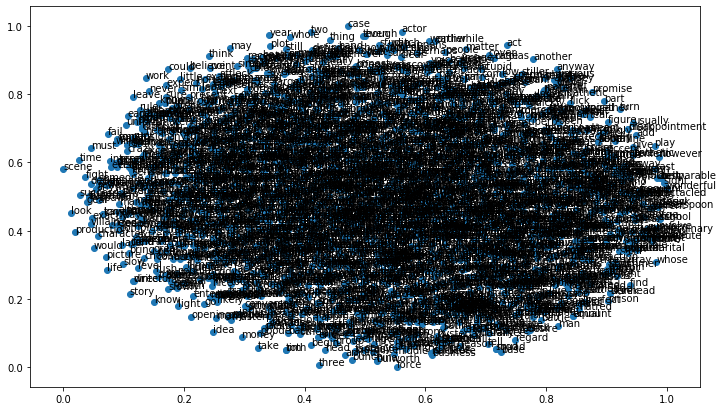

In [7]:
X_embedded = TSNE(
    n_components=2,
    perplexity=50,
    metric="cosine",
    n_jobs=-1,
    random_state=42
).fit_transform(vectors)
X_embedded = MinMaxScaler().fit_transform(X_embedded)

plt.figure(figsize=(12, 7))
ax = plt.subplot(1, 1, 1) #, projection='3d')
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', color='C0')
for i, txt in enumerate(words):
    plt.annotate(txt, (X_embedded[i, 0], X_embedded[i, 1]))
plt.show()

In [8]:
wd = "film"
print(f"Top 10 closest words to: {wd}")
print("-" * 20)
print("Cosine:")
for word, dist in w2v.wv.most_similar(wd):
    print("-", word, dist)

Top 10 closest words to: film
--------------------
Cosine:
- half 0.36499595642089844
- history 0.36336255073547363
- advocate 0.3543432950973511
- deux 0.34953680634498596
- pulls 0.3464128077030182
- recycle 0.34115129709243774
- rug 0.33611202239990234
- theatrical 0.32968950271606445
- fit 0.3249293565750122
- okay 0.322097510099411
